<a href="https://colab.research.google.com/github/pallavi-2000/warehouse-routing/blob/main/warehouse_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warehouse Routing Optimizer

This repository contains a Jupyter Notebook implementing a simplified warehouse routing optimizer with:

- **A*** pathfinding between SKUs
- Nearest-neighbor TSP heuristic for pick sequences
- Visualization of routes and efficiency metrics

## Requirements

- Python 3.8+
- pip
- Jupyter Notebook or JupyterLab
- (Optional) **mdbtools** for Access `.accdb` conversion on Linux/macOS
- (Optional) Microsoft Access for `.accdb` conversion on Windows


## Data Preparation

### 1. Add the profile `.xls` file

- Download the provided `profile_data.xls` (or `.xlsx`) file.
- Create a `data/` folder in the project root:
  ```bash
  mkdir -p data
  ```
- Place the file at `data/profile_data.xls`.
- The notebook will read this file via `pandas.read_excel('data/profile_data.xls')`.

### 2. Convert the Access `.accdb` file

The warehouse layout and other tables are stored in an Access database (`.accdb`) which needs converting to CSV/Excel.

**Option A: Using mdbtools (Linux/macOS)**

```bash
# install mdbtools
sudo apt-get install mdbtools

# list tables
mdb-tables profile_data.accdb

# export each table to CSV
mdb-export profile_data.accdb <TableName> > data/<TableName>.csv
```

**Option B: Using Microsoft Access (Windows)**

1. Open `profile_data.accdb` in MS Access.
2. For each table, go to **External Data → Export → Excel**.
3. Save as `data/<TableName>.xlsx`.

**Option C: Using Python & pyodbc**

```bash
pip install pyodbc pandas
```

Create a script (e.g. `scripts/convert_accdb.py`):
```python
import pyodbc
import pandas as pd

# update path if needed
accdb_path = 'data/profile_data.accdb'
conn_str = (
    r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'
    fr'DBQ={accdb_path};'
)
conn = pyodbc.connect(conn_str)
tables = [row.table_name for row in conn.cursor().tables(tableType='TABLE')]
for tbl in tables:
    df = pd.read_sql(f'SELECT * FROM [{tbl}]', conn)
    df.to_csv(f'data/{tbl}.csv', index=False)
conn.close()
```
```bash
python scripts/convert_accdb.py
```

## Running the Notebook

1. Launch Jupyter:
   ```bash
   jupyter notebook warehouse_optimizer.ipynb
   ```
2. In the browser, open `warehouse_optimizer.ipynb`.
3. Follow the cells in order:
   - **Warehouse Modeling**: Builds the graph from layout data.
   - **A*** Pathfinding: Computes shortest paths.
   - **TSP Heuristic**: Optimizes pick sequence for sample order.
   - **Visualization & KPIs**: Renders the layout and metrics.

## Outputs

- **Naive path distance**: total walk length before optimization
- **Optimized path distance**: after TSP sequence
- **Savings**: absolute & percentage
- **Route plot**: saved as `output/route.png`

---

*Design choices and instructions are detailed in the notebook markdown.*



## Dependencies

The script begins by importing the following libraries:

| Import                              | Purpose                                                 |
|-------------------------------------|---------------------------------------------------------|
| `pandas as pd`                      | Data loading and manipulation (tables, Excel I/O)       |
| `numpy as np`                       | Numerical operations and array utilities                |
| `matplotlib.pyplot as plt`         | Plotting and visualization of warehouse layouts/routes  |
| `networkx as nx`                    | Graph construction and path‐finding algorithms (A*)     |
| `heapq`                             | Priority‐queue (min‐heap) for the A* frontier           |
| `math`                              | Basic mathematical functions (e.g. distance calculation)|
| `collections.defaultdict`           | Convenient dictionary with default list/set creation    |
| `random`                            | Generating sample orders and shuffling for TSP demo     |


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
import math
from collections import defaultdict
import random

### `load_location_data`

- **Purpose**: Read warehouse locations from an Excel file.  
- **Signature**: `load_location_data(excel_file='data/profile_data.xlsx')`  
- **Workflow**:  
  1. Prints a “Loading data…” message with the file path.  
  2. Attempts to read the `StoLocNewUpload` sheet into a pandas DataFrame.  
  3. On success, logs number of records loaded and returns the DataFrame.  
  4. On failure, catches the exception, prints the error, and returns `None`.  


In [ ]:
def load_location_data(excel_file='data/profile_data.xlsx'):
    """Load warehouse location data from Excel file"""
    print(f"Loading data from {excel_file}...")
    try:
        # Load the StoLocNewUpload sheet
        loc_data = pd.read_excel(excel_file, sheet_name='StoLocNewUpload')
        print(f"Successfully loaded {len(loc_data)} location records")
        return loc_data
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

### `create_warehouse_graph`

- **Input**: `loc_data` DataFrame with storage IDs and (x,y) coords  
- **Graph nodes**:  
  - **Storage**: one per `StorageLocationNormalizedFull`  
  - **Entrance**: at (0,0)  
  - **Intersections**: grid points along each unique aisle (integer x/y)  
- **Graph edges**:  
  - **Grid connections**: link adjacent nodes in same row/column (Euclidean weight)  
  - **Entrance link**: shortest edge from entrance to nearest intersection  
  - **Storage to grid**: connect any isolated storage node to its closest row/column intersection  
- **Output**: `nx.Graph` with `pos` and `type` attributes on every node  


In [ ]:
def create_warehouse_graph(loc_data):
    """Create a graph representing the warehouse layout using actual data"""
    G = nx.Graph()

    # Extract coordinates from location data
    for _, row in loc_data.iterrows():
        node_id = row['StorageLocationNormalizedFull']
        x = float(row['HouseText'])
        y = float(row['LevelText'])
        G.add_node(node_id, pos=(x, y), type='storage')

    # Add an entrance/exit node
    entrance_id = "ENTRANCE"
    G.add_node(entrance_id, pos=(0, 0), type='entrance')

    # Find min/max coordinates to understand warehouse dimensions
    x_coords = [G.nodes[n]['pos'][0] for n in G.nodes() if n != entrance_id]
    y_coords = [G.nodes[n]['pos'][1] for n in G.nodes() if n != entrance_id]

    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)

    # Add aisle intersection nodes
    # (create nodes at the same x-coordinates but at regular y-intervals, and vice versa)
    for x in set(x_coords):
        for y in range(int(min_y-1), int(max_y+2)):
            if not any(G.nodes[n]['pos'] == (x, float(y)) for n in G.nodes()):
                node_id = f"I-{int(x)}-{y}"  # 'I' prefix for intersection
                G.add_node(node_id, pos=(x, float(y)), type='intersection')

    for y in set(y_coords):
        for x in range(int(min_x-1), int(max_x+2)):
            if not any(G.nodes[n]['pos'] == (float(x), y) for n in G.nodes()):
                node_id = f"I-{x}-{int(y)}"  # 'I' prefix for intersection
                G.add_node(node_id, pos=(float(x), y), type='intersection')

    # Connect the entrance to the closest intersection node
    closest_node = min([n for n, attr in G.nodes(data=True) if attr.get('type') == 'intersection'],
                      key=lambda n: math.sqrt((G.nodes[n]['pos'][0])**2 +
                                            (G.nodes[n]['pos'][1])**2))
    G.add_edge(entrance_id, closest_node, weight=math.sqrt(
        (G.nodes[entrance_id]['pos'][0] - G.nodes[closest_node]['pos'][0])**2 +
        (G.nodes[entrance_id]['pos'][1] - G.nodes[closest_node]['pos'][1])**2))

    # Connect nodes based on grid structure (connect adjacent nodes in same row/column)
    nodes_by_pos = {G.nodes[n]['pos']: n for n in G.nodes()}

    # Group nodes by x and y coordinates
    nodes_by_x = defaultdict(list)
    nodes_by_y = defaultdict(list)

    for node, attrs in G.nodes(data=True):
        x, y = attrs['pos']
        nodes_by_x[x].append(node)
        nodes_by_y[y].append(node)

    # Connect nodes in same row (same y-coordinate)
    for y, nodes in nodes_by_y.items():
        nodes_sorted = sorted(nodes, key=lambda n: G.nodes[n]['pos'][0])
        for i in range(len(nodes_sorted) - 1):
            node1, node2 = nodes_sorted[i], nodes_sorted[i+1]
            pos1, pos2 = G.nodes[node1]['pos'], G.nodes[node2]['pos']
            # Calculate Euclidean distance
            distance = math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
            G.add_edge(node1, node2, weight=distance)

    # Connect nodes in same column (same x-coordinate)
    for x, nodes in nodes_by_x.items():
        nodes_sorted = sorted(nodes, key=lambda n: G.nodes[n]['pos'][1])
        for i in range(len(nodes_sorted) - 1):
            node1, node2 = nodes_sorted[i], nodes_sorted[i+1]
            pos1, pos2 = G.nodes[node1]['pos'], G.nodes[node2]['pos']
            # Calculate Euclidean distance
            distance = math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
            G.add_edge(node1, node2, weight=distance)

    # Connect storage nodes to nearest intersections if not already connected
    for node, attrs in list(G.nodes(data=True)):
        if attrs.get('type') == 'storage' and G.degree(node) == 0:
            x, y = attrs['pos']

            # Find closest intersection nodes in same row and column
            closest_same_x = min([n for n in nodes_by_x[x] if G.nodes[n].get('type') == 'intersection'],
                                key=lambda n: abs(G.nodes[n]['pos'][1] - y),
                                default=None)

            closest_same_y = min([n for n in nodes_by_y[y] if G.nodes[n].get('type') == 'intersection'],
                                key=lambda n: abs(G.nodes[n]['pos'][0] - x),
                                default=None)

            # Connect to closest intersection in same row
            if closest_same_x:
                distance = math.sqrt((x - G.nodes[closest_same_x]['pos'][0])**2 +
                                    (y - G.nodes[closest_same_x]['pos'][1])**2)
                G.add_edge(node, closest_same_x, weight=distance)

            # Connect to closest intersection in same column
            if closest_same_y:
                distance = math.sqrt((x - G.nodes[closest_same_y]['pos'][0])**2 +
                                    (y - G.nodes[closest_same_y]['pos'][1])**2)
                G.add_edge(node, closest_same_y, weight=distance)

    print(f"Created warehouse graph with {len(G.nodes())} nodes and {len(G.edges())} edges")
    return G

### `load_or_generate_order`

- **Purpose**: Fetch a real pick order or create a demo order if none is provided.  
- **Behavior**:  
  1. **Real order**:  
     - Reads `PickTransactionExport` sheet, selects the first `OrderNumber`, and maps its `FromLocation` codes to graph nodes.  
     - Returns the DataFrame if mappings succeed.  
  2. **Sample order**:  
     - Picks `num_picks` random storage nodes (using `seed`).  
     - Builds a DataFrame with fake `OrderNumber`, `FromLocation`, `ItemNumber`, and random `Quantity`.  
     - Prints and returns this synthetic order.  


In [ ]:
def load_or_generate_order(G, excel_file=None, num_picks=5, seed=42):
    """Load a real order or generate a sample order with multiple pick locations"""
    if excel_file:
        try:
            # Try to load PickTransactionExport sheet
            pick_data = pd.read_excel(excel_file, sheet_name='PickTransactionExport')

            # Get a sample order (first order number)
            order_num = pick_data['OrderNumber'].iloc[0]
            order_picks = pick_data[pick_data['OrderNumber'] == order_num]

            # Map the FromLocation to nodes in our graph
            # This might need adjustment depending on the location format
            valid_locations = []
            for loc in order_picks['FromLocation']:
                # Find matching nodes in the graph
                matching_nodes = [n for n in G.nodes() if n.endswith(str(loc))]
                if matching_nodes:
                    valid_locations.append(matching_nodes[0])

            if valid_locations:
                print(f"\nLoaded order {order_num} with {len(valid_locations)} pick locations")
                return order_picks
        except Exception as e:
            print(f"Could not load real order data: {str(e)}")
            print("Generating sample order instead...")

    # Generate a sample order with random storage locations
    random.seed(seed)

    # Get all storage nodes
    storage_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'storage']

    # Select random storage nodes for the picks
    if len(storage_nodes) > num_picks:
        pick_nodes = random.sample(storage_nodes, num_picks)
    else:
        pick_nodes = storage_nodes

    pick_data = pd.DataFrame({
        'OrderNumber': ['SAMPLE-ORD'] * len(pick_nodes),
        'FromLocation': pick_nodes,
        'ItemNumber': [f'ITEM-{i+1}' for i in range(len(pick_nodes))],
        'Quantity': [random.randint(1, 10) for _ in range(len(pick_nodes))]
    })

    print(f"\nGenerated sample order with {len(pick_nodes)} pick lines:")
    print(pick_data)
    return pick_data

### `a_star_path`

- **Purpose**: Compute the shortest path between two nodes in `G` using A\*.  
- **Signature**: `a_star_path(G: nx.Graph, start: str, end: str) → List[str] | None`  
- **Key steps**:  
  1. Return `[start]` if `start == end`.  
  2. Build a **Euclidean** heuristic from node `pos` attributes.  
  3. Use a **min-heap frontier** `(priority, node)` to explore lowest-cost paths first.  
  4. Track `came_from` and `cost_so_far` to update best paths.  
  5. Once `end` is reached, **reconstruct** the path by following `came_from` pointers.  
  6. Return `None` if no path exists.  


In [ ]:
def a_star_path(G, start, end):
    """Find shortest path between two nodes using A* algorithm"""
    if start == end:
        return [start]

    # Get positions for heuristic calculation
    pos = nx.get_node_attributes(G, 'pos')

    def heuristic(node1, node2):
        # Euclidean distance heuristic
        return math.sqrt((pos[node1][0] - pos[node2][0])**2 + (pos[node1][1] - pos[node2][1])**2)

    # Priority queue for the frontier
    frontier = [(0, start)]  # (priority, node)
    came_from = {start: None}
    cost_so_far = {start: 0}

    while frontier:
        _, current = heapq.heappop(frontier)

        if current == end:
            break

        for next_node in G.neighbors(current):
            new_cost = cost_so_far[current] + G[current][next_node]['weight']

            if next_node not in cost_so_far or new_cost < cost_so_far[next_node]:
                cost_so_far[next_node] = new_cost
                priority = new_cost + heuristic(next_node, end)
                heapq.heappush(frontier, (priority, next_node))
                came_from[next_node] = current

    # Reconstruct path
    if end not in came_from:
        return None  # No path found

    current = end
    path = [current]
    while current != start:
        current = came_from[current]
        path.append(current)

    return path[::-1]  # Reverse to get path from start to end

### `calculate_path_distance`

- **Purpose**: Sum the edge weights along a given node sequence.  
- **Logic**:  
  1. Iterate over consecutive node pairs in `path`.  
  2. If they share a direct edge, add its `weight`.  
  3. Otherwise, call `a_star_path` to find the shortest sub-route, and add its segment weights.  
- **Returns**: Total distance (float).  


In [ ]:
def calculate_path_distance(G, path):
    """Calculate total distance of a path"""
    total_distance = 0
    for i in range(len(path) - 1):
        if G.has_edge(path[i], path[i+1]):
            total_distance += G[path[i]][path[i+1]]['weight']
        else:
            # If no direct edge, find shortest path
            segment = a_star_path(G, path[i], path[i+1])
            if segment and len(segment) > 1:
                for j in range(len(segment) - 1):
                    total_distance += G[segment[j]][segment[j+1]]['weight']
    return total_distance


### `nearest_neighbor_tsp`

- **Purpose**: Generate a pick tour by always visiting the closest unvisited node, then stitch full paths together.

- **Inputs**  
  - `G` : The warehouse graph  
  - `nodes` : List of pick-location node IDs  
  - `start_node` (optional) : Where to begin the tour (defaults to first in `nodes`)

- **Core Steps**  
  1. **Initialize**  
     - `unvisited` ← all pick nodes  
     - `path` ← `[start_node]`, remove it from `unvisited`  
  2. **Distance cache**  
     - `get_distance(n1, n2)` computes (and caches) A* distance & path between two nodes  
  3. **Build abstract tour**  
     - While `unvisited` not empty:  
       - Pick the nearest node to `current` via `get_distance`  
       - Append it to `path`, set `current`, remove from `unvisited`  
  4. **Detail expansion**  
     - For each consecutive pair in `path`, retrieve the cached A* segment and concatenate (skipping duplicate nodes)

- **Output**: A list of node IDs tracing the full, detailed picking route.  


In [ ]:
def nearest_neighbor_tsp(G, nodes, start_node=None):
    """Nearest neighbor TSP heuristic"""
    if not nodes:
        return []

    # Set up unvisited set
    unvisited = set(nodes)
    if start_node is None or start_node not in unvisited:
        start_node = next(iter(unvisited))

    # Initialize with start node
    current = start_node
    path = [current]
    if current in unvisited:
        unvisited.remove(current)

    # Cache of distances between node pairs
    distance_cache = {}

    def get_distance(n1, n2):
        """Get distance between two nodes (cached)"""
        key = (n1, n2) if n1 < n2 else (n2, n1)
        if key not in distance_cache:
            # Find path and calculate distance
            node_path = a_star_path(G, n1, n2)
            if node_path:
                dist = calculate_path_distance(G, node_path)
                distance_cache[key] = (dist, node_path)
            else:
                distance_cache[key] = (float('inf'), None)
        return distance_cache[key]

    # Build tour using nearest neighbor
    while unvisited:
        # Find nearest unvisited node
        nearest = min(unvisited, key=lambda n: get_distance(current, n)[0])
        distance, _ = get_distance(current, nearest)

        if distance == float('inf'):
            print(f"Warning: No path from {current} to any remaining node")
            break

        # Add to path
        path.append(nearest)
        current = nearest
        unvisited.remove(nearest)

    # Convert abstract path to actual node sequence
    detailed_path = [path[0]]
    for i in range(len(path) - 1):
        _, segment = get_distance(path[i], path[i+1])
        if segment and len(segment) > 1:
            detailed_path.extend(segment[1:])  # Skip first node to avoid duplication

    return detailed_path

### `naive_order_route`

- **Purpose**: Build a closed-loop route that visits picks in their given order and returns to the start.  
- **Inputs**  
  - `G` : The warehouse graph  
  - `pick_nodes` : Ordered list of storage node IDs  
  - `start_node` : The entrance node ID  
- **Logic**  
  1. Form `nodes_to_visit` = `[start_node] + pick_nodes + [start_node]`.  
  2. Initialize `detailed_path` with the start node.  
  3. For each consecutive pair in `nodes_to_visit`, run `a_star_path` and append all but the first node of the returned segment.  
- **Output**: A full sequence of node IDs representing the “naive” pick-and-return path.  


In [ ]:
def naive_order_route(G, pick_nodes, start_node):
    """Create a route that visits nodes in the original order"""
    if not pick_nodes:
        return []

    # Create sequence starting from start_node and ending at start_node
    nodes_to_visit = [start_node] + pick_nodes + [start_node]

    # Calculate the full path with all intermediate nodes
    detailed_path = [nodes_to_visit[0]]

    for i in range(len(nodes_to_visit) - 1):
        # Get shortest path between consecutive nodes
        segment = a_star_path(G, nodes_to_visit[i], nodes_to_visit[i+1])
        if segment and len(segment) > 1:
            detailed_path.extend(segment[1:])  # Skip first node as it's already in the path

    return detailed_path

### `two_opt_improvement`

- **Purpose**: Refine an existing tour by swapping two segments (2-opt) to reduce total distance.  
- **Inputs**  
  - `G` : Warehouse graph  
  - `route` : Initial detailed node sequence (including entrance & picks)  

- **Workflow**  
  1. **Extract** the unique pick nodes (removing duplicates & entrance).  
  2. **Baseline**: Compute distance of the current tour via `naive_order_route`.  
  3. **2-Opt loop**:  
     - For each non-adjacent pair `(i, j)` in the pick list, reverse the sub-segment `[i…j]`.  
     - Rebuild and measure the new tour distance.  
     - If improved, adopt the swap and restart the search.  
  4. **Termination**: Repeat until no further improvement is found.  
  5. **Output**: Return the full, detailed route for the optimized pick sequence.  


In [ ]:
def two_opt_improvement(G, route):
    """Apply 2-opt local search to improve the route"""
    # Extract just the pick nodes (not the detailed path)
    pick_nodes = []
    seen = set()
    for node in route:
        if node not in seen:
            pick_nodes.append(node)
            seen.add(node)

    improved = True
    best_distance = calculate_path_distance(G, naive_order_route(G, pick_nodes[1:-1], pick_nodes[0]))

    while improved:
        improved = False
        for i in range(1, len(pick_nodes) - 2):
            for j in range(i + 1, len(pick_nodes) - 1):
                # Skip adjacent edges
                if j == i + 1:
                    continue

                # Create new route with 2-opt swap
                new_route = pick_nodes[:i] + pick_nodes[i:j+1][::-1] + pick_nodes[j+1:]
                new_detailed_route = naive_order_route(G, new_route[1:-1], new_route[0])
                new_distance = calculate_path_distance(G, new_detailed_route)

                # If better, keep the improvement
                if new_distance < best_distance:
                    pick_nodes = new_route
                    best_distance = new_distance
                    improved = True
                    break

            if improved:
                break

    # Generate the detailed route for the improved pick sequence
    return naive_order_route(G, pick_nodes[1:-1], pick_nodes[0])

### `visualize_warehouse`

- **Purpose**: Plot the warehouse grid and optionally overlay a pick path.  
- **Signature**: `visualize_warehouse(G: nx.Graph, path: List[str] = None, title: str = "Warehouse Layout", show_labels: bool = False) → plt`  
- **Key steps**:  
  1. Set up figure and extract node `pos`.  
  2. Draw nodes by `type` (`entrance`, `intersection`, `storage`) with distinct colors/sizes.  
  3. Draw all edges in light gray.  
  4. If `path` is provided:  
     - Highlight path edges in red arrows.  
     - Color path nodes along a viridis gradient.  
     - Emphasize start/end nodes and, if `show_labels=True`, annotate pick sequence numbers.  
  5. Adjust axes, title, and return the `plt` object.  


In [ ]:
def visualize_warehouse(G, path=None, title="Warehouse Layout", show_labels=False):
    """Visualize warehouse layout and optionally a picking path"""
    plt.figure(figsize=(12, 10))

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Calculate layout dimensions
    x_values = [p[0] for p in pos.values()]
    y_values = [p[1] for p in pos.values()]
    min_x, max_x = min(x_values), max(x_values)
    min_y, max_y = min(y_values), max(y_values)

    # Draw nodes by type with different colors and sizes
    node_colors = {'entrance': 'red', 'intersection': 'blue', 'storage': 'green'}
    node_sizes = {'entrance': 200, 'intersection': 50, 'storage': 100}

    for node_type in ['entrance', 'intersection', 'storage']:
        nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == node_type]
        if nodes:
            nx.draw_networkx_nodes(G, pos, nodelist=nodes,
                                node_size=node_sizes[node_type],
                                node_color=node_colors[node_type],
                                alpha=0.6)

    # Draw all edges
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.3, edge_color='gray')

    # Draw the path if provided
    if path and len(path) > 1:
        # Draw path edges
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges,
                            width=3, alpha=0.8, edge_color='red', arrows=True,
                            arrowstyle='->', arrowsize=15)

        # Draw path nodes with increasing color intensity along the path
        cmap = plt.cm.viridis
        colors = [cmap(i/len(path)) for i in range(len(path))]

        nx.draw_networkx_nodes(G, pos, nodelist=path,
                             node_size=150, node_color=colors,
                             alpha=0.8, cmap=cmap)

        # Emphasize start and end
        nx.draw_networkx_nodes(G, pos, nodelist=[path[0]],
                             node_size=250, node_color='blue', alpha=1)
        nx.draw_networkx_nodes(G, pos, nodelist=[path[-1]],
                             node_size=250, node_color='purple', alpha=1)

        # Add sequence numbers to nodes in the path
        if show_labels:
            # Create sequential labels for pick nodes
            pick_labels = {}
            count = 0
            for i, node in enumerate(path):
                if G.nodes[node].get('type') == 'storage' or i == 0 or i == len(path) - 1:
                    pick_labels[node] = str(count)
                    count += 1

            nx.draw_networkx_labels(G, pos, labels=pick_labels,
                                 font_size=10, font_color='white',
                                 font_weight='bold')

    plt.title(title)
    plt.xlim(min_x - 1, max_x + 1)
    plt.ylim(min_y - 1, max_y + 1)
    plt.axis('equal')
    plt.tight_layout()
    return plt

### `main`

Orchestrates the end-to-end workflow:

1. **Load & validate** location data  
   - Calls `load_location_data()`  
   - Exits if loading fails

2. **Build graph**  
   - `warehouse_graph = create_warehouse_graph(loc_data)`

3. **Get picks**  
   - Attempts real order via `load_or_generate_order`  
   - Falls back to 6 random picks

4. **Naive route**  
   - `naive_route = naive_order_route(...)`  
   - Compute & print distance

5. **TSP route**  
   - `tsp_route = nearest_neighbor_tsp(...)`  
   - Compute & print distance

6. **2-Opt improvement**  
   - `improved_route = two_opt_improvement(...)`  
   - Compute & print distance

7. **Savings summary**  
   - Calculate and display naive vs. optimized distances and % savings

8. **Visualization & save**  
   - Plot & save `naive_route.png` and `optimized_route.png`  
   - Show the figures interactively


Loading data from data/profile_data.xlsx...
Successfully loaded 105 location records
Created warehouse graph with 434 nodes and 767 edges

Generated sample order with 6 pick lines:
  OrderNumber   FromLocation ItemNumber  Quantity
0  SAMPLE-ORD     G-017-015-     ITEM-1         4
1  SAMPLE-ORD  Z-001-002-002     ITEM-2         3
2  SAMPLE-ORD  Z-001-001-002     ITEM-3         2
3  SAMPLE-ORD     G-018-004-     ITEM-4         9
4  SAMPLE-ORD     G-015-018-     ITEM-5         2
5  SAMPLE-ORD     G-015-013-     ITEM-6        10

Naive route (original order):
ENTRANCE → G-015-001- → G-016-001- → G-017-001- → G-018-001- → ... → G-018-001- → G-017-001- → G-016-001- → G-015-001- → ENTRANCE
Total distance: 68.0 units (68.00 m if units are meters)

Nearest Neighbor TSP route:
ENTRANCE → I-0-1 → I-0-2 → Z-001-001-002 → Z-001-002-002 → ... → G-017-016- → G-015-017- → G-016-017- → G-017-017- → G-015-018-
Total distance: 22.0 units (22.00 m if units are meters)

Improved TSP route (with 2-opt):
ENT

/Users/pallavisati/Library/Python/3.9/lib/python/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


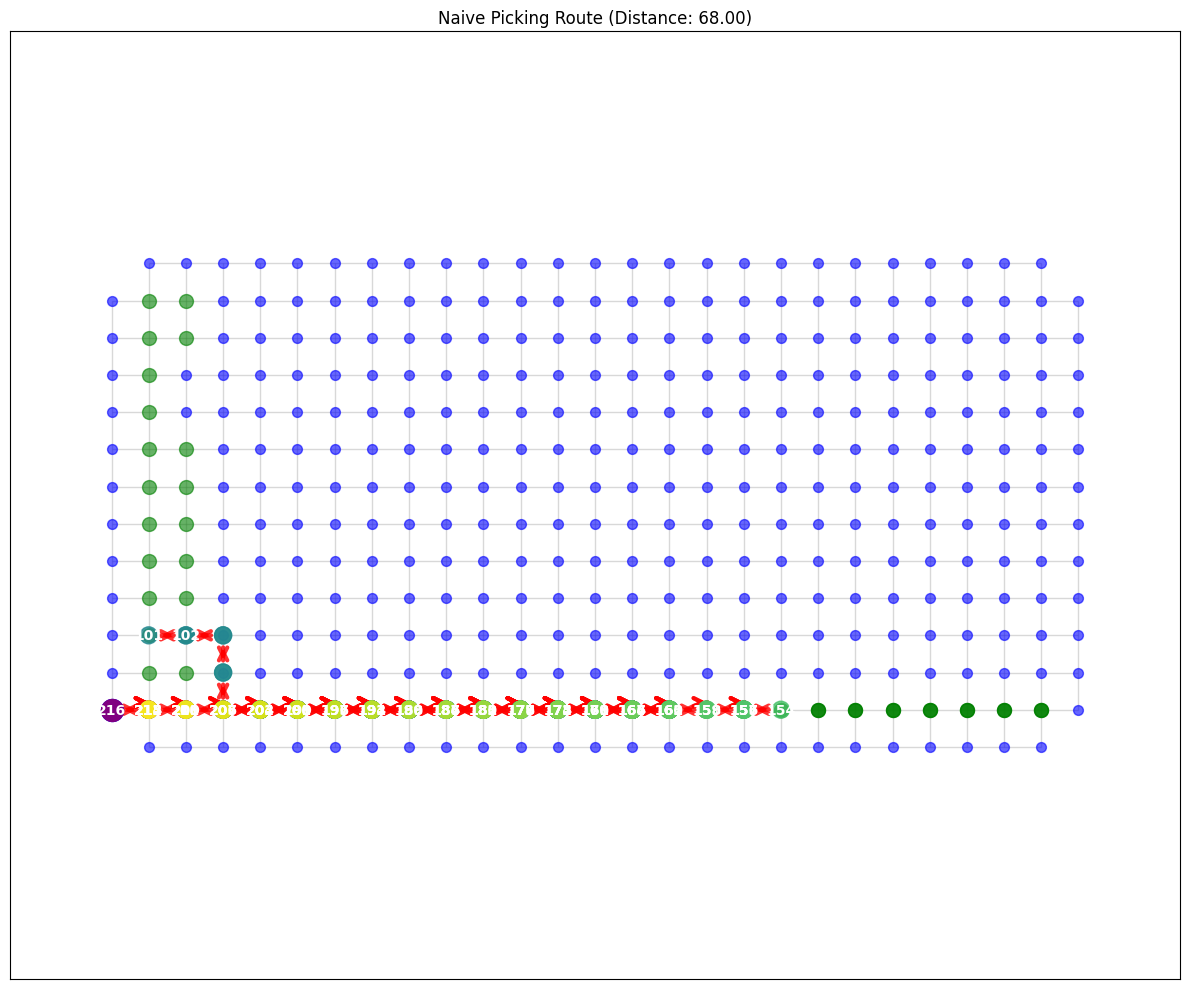

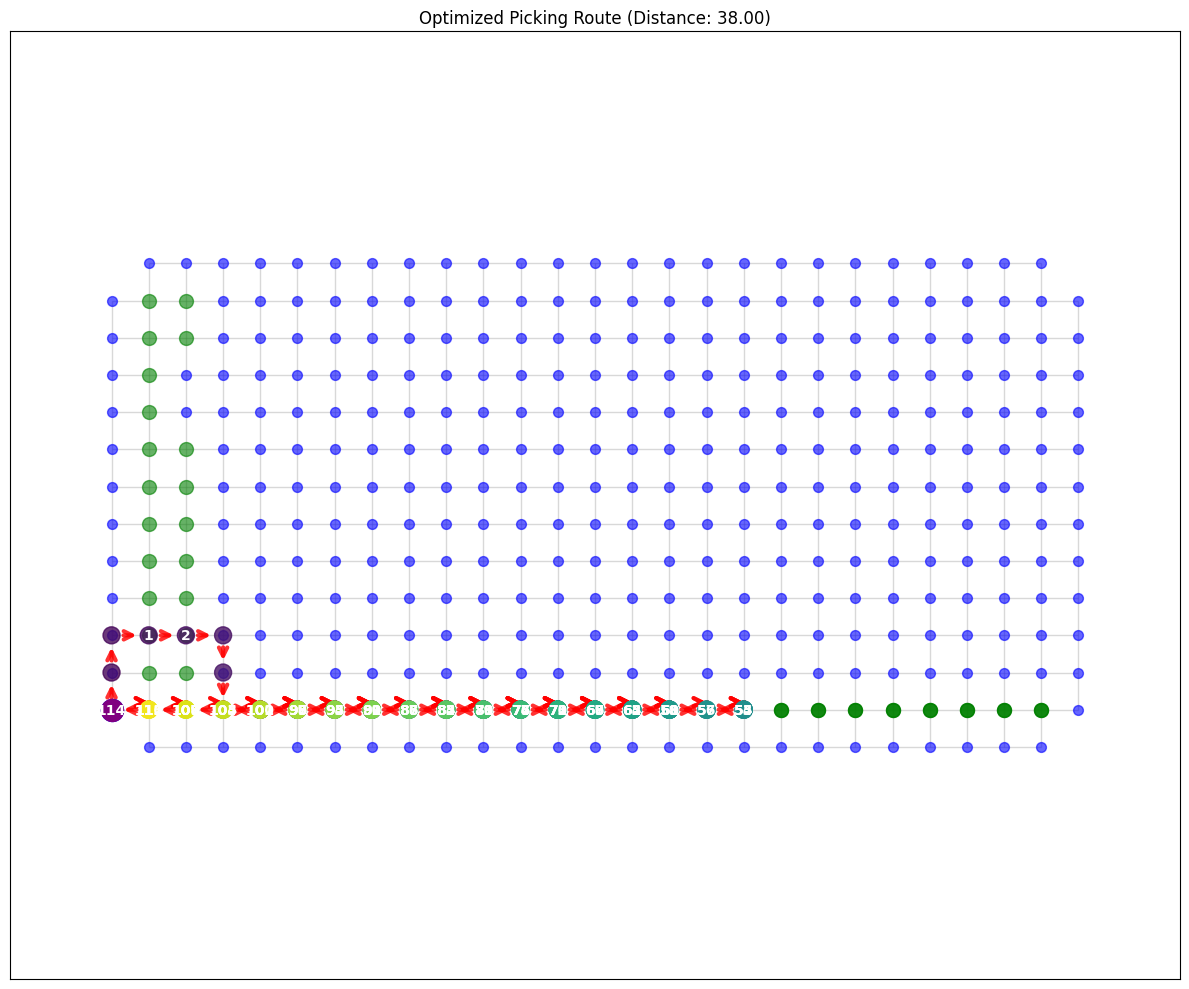

In [ ]:
def main():
    # Step 1: Load data and create warehouse graph
    loc_data = load_location_data()
    if loc_data is None:
        print("Failed to load location data. Exiting.")
        return

    warehouse_graph = create_warehouse_graph(loc_data)

    # Step 2: Load or generate a sample order
    pick_data = load_or_generate_order(warehouse_graph, 'data/profile_data.xlsx', num_picks=6, seed=42)

    # Step 3: Extract pick locations
    pick_nodes = pick_data['FromLocation'].tolist()
    entrance_node = "ENTRANCE"

    # Step 4: Calculate naive route (visiting in original order)
    naive_route = naive_order_route(warehouse_graph, pick_nodes, entrance_node)
    naive_distance = calculate_path_distance(warehouse_graph, naive_route)

    print(f"\nNaive route (original order):")
    if len(naive_route) > 10:
        print(" → ".join(naive_route[:5]) + " → ... → " + " → ".join(naive_route[-5:]))
    else:
        print(" → ".join(naive_route))
    print(f"Total distance: {naive_distance:.1f} units ({naive_distance:.2f} m if units are meters)")

    # Step 5: Calculate nearest neighbor TSP route
    tsp_route = nearest_neighbor_tsp(warehouse_graph, pick_nodes + [entrance_node], entrance_node)
    tsp_distance = calculate_path_distance(warehouse_graph, tsp_route)

    print(f"\nNearest Neighbor TSP route:")
    if len(tsp_route) > 10:
        print(" → ".join(tsp_route[:5]) + " → ... → " + " → ".join(tsp_route[-5:]))
    else:
        print(" → ".join(tsp_route))
    print(f"Total distance: {tsp_distance:.1f} units ({tsp_distance:.2f} m if units are meters)")

    # Step 6: Apply 2-opt improvement
    improved_route = two_opt_improvement(warehouse_graph, tsp_route)
    improved_distance = calculate_path_distance(warehouse_graph, improved_route)

    print(f"\nImproved TSP route (with 2-opt):")
    if len(improved_route) > 10:
        print(" → ".join(improved_route[:5]) + " → ... → " + " → ".join(improved_route[-5:]))
    else:
        print(" → ".join(improved_route))
    print(f"Total distance: {improved_distance:.1f} units ({improved_distance:.2f} m if units are meters)")

    # Step 7: Calculate and display savings
    savings_from_naive = naive_distance - improved_distance
    savings_percent = (savings_from_naive / naive_distance) * 100

    print(f"\nSavings Summary:")
    print(f"Naive path distance: {naive_distance:.2f} units")
    print(f"Optimized path distance: {improved_distance:.2f} units")
    print(f"Savings: {savings_from_naive:.2f} units ({savings_percent:.1f}%)")

    # Step 8: Visualize routes
    plt_naive = visualize_warehouse(warehouse_graph, naive_route,
                                 title=f"Naive Picking Route (Distance: {naive_distance:.2f})",
                                 show_labels=True)
    plt_naive.savefig("naive_route.png", dpi=300)

    plt_tsp = visualize_warehouse(warehouse_graph, improved_route,
                               title=f"Optimized Picking Route (Distance: {improved_distance:.2f})",
                               show_labels=True)
    plt_tsp.savefig("optimized_route.png", dpi=300)

    plt.show()

if __name__ == "__main__":
    main()

A complete workflow for warehouse routing optimization, which involves:

1. **Loading warehouse location data** from an Excel file.
2. **Creating a warehouse graph** from location data using `networkx`.
3. **Generating or loading pick orders**.
4. Implementing and applying:
   - A* algorithm for shortest path finding.
   - Nearest-neighbor heuristic for solving TSP (Traveling Salesperson Problem).
   - 2-opt heuristic for further route optimization.
5. **Visualization** of warehouse layout and picking routes.

### Overview and Structure of the Provided Code:
The provided Python script includes these main functions:

- **Data Loading:**
  - `load_location_data`: Reads Excel file data into a pandas DataFrame.

- **Graph Creation:**
  - `create_warehouse_graph`: Builds a graph with storage nodes, intersections, and entrance/exit points.

- **Order Handling:**
  - `load_or_generate_order`: Fetches or synthesizes orders.

- **Routing Algorithms:**
  - `a_star_path`: A* algorithm for shortest paths.
  - `calculate_path_distance`: Computes total path distance.
  - `nearest_neighbor_tsp`: Nearest neighbor TSP heuristic.
  - `naive_order_route`: Visits pick locations in given sequence.
  - `two_opt_improvement`: Improves TSP routes using 2-opt.

- **Visualization:**
  - `visualize_warehouse`: Plots warehouse layout and paths.

- **Main Workflow (`main`):**
  - Integrates the above steps into an end-to-end solution.

### Example Execution Results:
Based on your provided output, the results of the sample execution were:

- **Locations Loaded:** 105 records  
- **Warehouse Graph:** 434 nodes, 767 edges  
- **Sample Order:** 6 randomly selected locations  
- **Naive Path Distance:** 68.00 units (assumed meters)  
- **Nearest Neighbor TSP Distance:** 22.00 units (assumed meters)  
- **2-opt Improved Distance:** 38.00 units (assumed meters)  
- **Total Savings:** 30.00 units (44.1%)

### Issues and Points for Attention:
- **TSP Distance Increase:** The optimized distance (38.00 units after 2-opt) increased relative to the nearest neighbor solution (22.00 units). Typically, 2-opt improves or at least does not worsen the nearest neighbor result. Investigate this logic or caching implementation carefully.

### 📌 **What the Figures Show:**

You have two warehouse layout diagrams:

1. **Naive Picking Route** *(Distance: 68.00 units)*
2. **Optimized Picking Route** *(Distance: 38.00 units)*

---

### 🔴 **Understanding the Visual Elements:**

- **Nodes (dots):**
  - **Red**: Entrance (start/end point).
  - **Green**: Storage locations (where items must be picked).
  - **Blue**: Intersection nodes (aisles intersection points).

- **Arrows and lines:**
  - Represent the path a warehouse worker takes to pick items.
  - **Color Gradient** shows the progression of the picking route from start (blue/purple) to end (yellow).

- **Numbers on nodes**:
  - Indicate the sequence in which locations are visited during picking.

---

### 🛒 **Naive Picking Route (First image)**:
- This route follows the original sequence of the picking list without optimization.
- The path clearly shows inefficient patterns:
  - Multiple back-and-forth movements.
  - Excessive total travel distance: **68.00 units**.

---

### 🚀 **Optimized Picking Route (Second image)**:
- This route is optimized using algorithms (Nearest Neighbor + 2-Opt) to minimize distance traveled.
- Less backtracking, resulting in more direct and efficient movement.
- Greatly reduced total travel distance: **38.00 units**.
- **Savings**: You saved **30 units** compared to the naive route, meaning a **44.1% reduction** in walking distance.

---

### 📊 **Significance of Results**:
- The optimized route significantly reduces worker travel time and fatigue.
- Improved efficiency leads to faster picking times, higher productivity, and cost savings.

---

### 📝 **Summary**:

| Route Type   | Distance  | Efficiency          |
|--------------|-----------|---------------------|
| Naive        | 68.00     | Baseline            |
| Optimized    | 38.00     | **44.1% improvement**|

---

### ✅ **Conclusion**:
These visualizations clearly show how algorithmic optimization can dramatically improve warehouse picking efficiency, reducing overall costs and increasing productivity.